# An RNN for short-term predictions
This model will try to predict the next value in a short sequence based on historical data. This can be used for example to forecast demand based on a couple of weeks of sales data.

<div class="alert alert-block alert-warning">
This is the solution file. The corresponding tutorial file is [00_RNN_predictions_playground.ipynb](00_RNN_predictions_playground.ipynb)
</div>

<div class="alert alert-block alert-info">
**Assignment #5**: The [final cell](#benchmark) in this notebook has a loop that benchmarks all the neural network architectures. Run it once, then if you have the time, try reducing the data sequence length from 16 to 8 (SEQLEN=8) and see how well you can still predict the next value.
</div>

In [1]:
import numpy as np
import utils_datagen
import utils_display
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version: " + tf.__version__)

Tensorflow version: 1.7.0


## Generate fake dataset

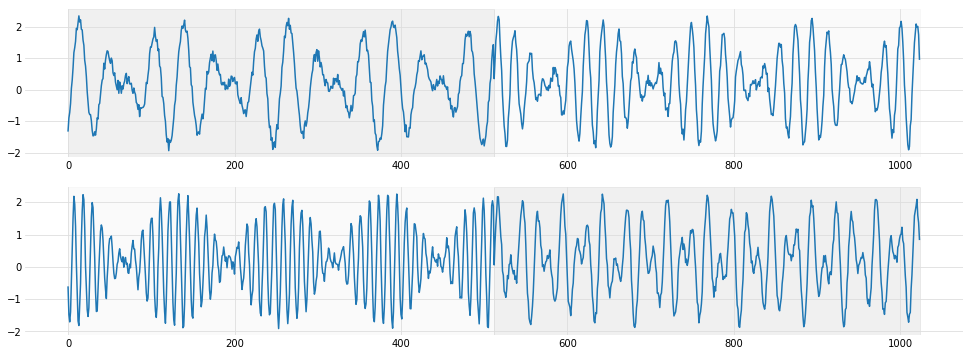

In [2]:
DATA_SEQ_LEN = 1024*128
data = np.concatenate([utils_datagen.create_time_series(waveform, DATA_SEQ_LEN) for waveform in utils_datagen.Waveforms])
utils_display.picture_this_1(data, DATA_SEQ_LEN)

## Hyperparameters

In [3]:
NB_EPOCHS = 10      # number of times the data is repeated during training
RNN_CELLSIZE = 32   # size of the RNN cells
SEQLEN = 16         # unrolled sequence length
BATCHSIZE = 32      # mini-batch size

## Visualize training sequences
This is what the neural network will see during training.

Tensor shape of a batch of training sequences: (32, 16)
Random excerpt:


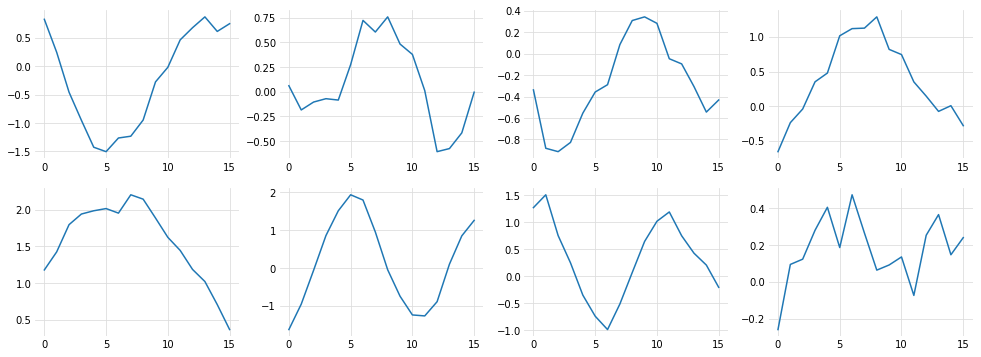

In [4]:
utils_display.picture_this_2(data, BATCHSIZE, SEQLEN) # execute multiple times to see different sample sequences

## The model definition
When executed, these functions instantiates the Tensorflow graph for our model.

In [5]:
# tree simplistic predictive models: can you beat them ?
def simplistic_models(X):
    # "random" model
    Yrnd = tf.random_uniform([tf.shape(X)[0]], -2.0, 2.0) # tf.shape(X)[0] is the batch size
    # "same as last" model
    Ysal = X[:,-1]
    # "trend from last two" model
    Ytfl = X[:,-1] + (X[:,-1] - X[:,-2])
    return Yrnd, Ysal, Ytfl

In [6]:
# linear model (RMSE: 0.36, with shuffling: 0.17)
def linear_model(X):
    Yout = tf.layers.dense(X, 1) # output shape [BATCHSIZE, 1]
    return Yout

In [7]:
# 2-layer dense model (RMSE: 0.38, with shuffling: 0.15-0.18)
def DNN_model(X):
    Y = tf.layers.dense(X, SEQLEN//2, activation=tf.nn.relu)
    Yout = tf.layers.dense(Y, 1, activation=None) # output shape [BATCHSIZE, 1]
    return Yout

In [8]:
# convolutional (RMSE: 0.31, with shuffling: 0.16)
def CNN_model(X):
    X = tf.expand_dims(X, axis=2) # [BATCHSIZE, SEQLEN, 1] is necessary for conv model
    Y = tf.layers.conv1d(X, filters=8, kernel_size=4, activation=tf.nn.relu, padding="same") # [BATCHSIZE, SEQLEN, 8]
    Y = tf.layers.conv1d(Y, filters=16, kernel_size=3, activation=tf.nn.relu, padding="same") # [BATCHSIZE, SEQLEN, 8]
    Y = tf.layers.conv1d(Y, filters=8, kernel_size=1, activation=tf.nn.relu, padding="same") # [BATCHSIZE, SEQLEN, 8]
    Y = tf.layers.max_pooling1d(Y, pool_size=2, strides=2)  # [BATCHSIZE, SEQLEN//2, 8]
    Y = tf.layers.conv1d(Y, filters=8, kernel_size=3, activation=tf.nn.relu, padding="same")  # [BATCHSIZE, SEQLEN//2, 8]
    Y = tf.layers.max_pooling1d(Y, pool_size=2, strides=2)  # [BATCHSIZE, SEQLEN//4, 8]
    # mis-using a conv layer as linear regression :-)
    Yout = tf.layers.conv1d(Y, filters=1, kernel_size=SEQLEN//4, activation=None, padding="valid") # output shape [BATCHSIZE, 1, 1]
    Yout = tf.squeeze(Yout, axis=-1) # output shape [BATCHSIZE, 1]
    return Yout

![deep RNN schematic](images/RNN1.svg)
<div style="text-align: right; font-family: monospace">
  X shape [BATCHSIZE, SEQLEN, 1]<br/>
  Y shape [BATCHSIZE, SEQLEN, 1]<br/>
  H shape [BATCHSIZE, RNN_CELLSIZE*NLAYERS]
</div>

In [9]:
# RNN model (RMSE: 0.38, with shuffling 0.14, the same with loss on last 8)
def RNN_model(X, n=1):
    # 2-layer RNN
    X = tf.expand_dims(X, axis=2) # [BATCHSIZE, SEQLEN, 1] is necessary for RNN model
    cell1 = tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE)
    cell2 = tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE)
    cell = tf.nn.rnn_cell.MultiRNNCell([cell1, cell2], state_is_tuple=False)
    Yn, H = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32) # Yn [BATCHSIZE, SEQLEN, RNN_CELLSIZE]
    
    # regression head
    batchsize = tf.shape(X)[0]
    Yn = tf.reshape(Yn, [batchsize*SEQLEN, RNN_CELLSIZE])
    Yr = tf.layers.dense(Yn, 1) # Yr [BATCHSIZE*SEQLEN, 1]
    Yr = tf.reshape(Yr, [batchsize, SEQLEN, 1]) # Yr [BATCHSIZE, SEQLEN, 1]
    
    # In this RNN model, you can compute the loss on the last predicted item or the lats n predicted items
    # Last n is slightly better.
    Yout = Yr[:,-n:SEQLEN,:] # last item(s) in sequence: output shape [BATCHSIZE, n, 1]
    Yout = tf.squeeze(Yout, axis=-1)
    return Yout

In [10]:
def RNN_model_N(X): return RNN_model(X, n=SEQLEN//2)

In [11]:
def model_fn(features, labels, model):
    X = features # shape [BATCHSIZE, SEQLEN]
    
    Y = model(X)

    last_label = labels[:, -1] # last item in sequence: the target value to predict
    last_labels = labels[:, -tf.shape(Y)[1]:SEQLEN] # last p items in sequence (as many as in Y), useful for RNN_model(X, n>1)

    loss = tf.losses.mean_squared_error(Y, last_labels) # loss computed on last label(s)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = optimizer.minimize(loss)
    Yrnd, Ysal, Ytfl = simplistic_models(X)
    eval_metrics = {"RMSE": tf.sqrt(loss),
                    # compare agains three simplistic predictive models: can you beat them ?
                    "RMSErnd": tf.sqrt(tf.losses.mean_squared_error(Yrnd, last_label)),
                    "RMSEsal": tf.sqrt(tf.losses.mean_squared_error(Ysal, last_label)),
                    "RMSEtfl": tf.sqrt(tf.losses.mean_squared_error(Ytfl, last_label))}
    
    Yout = Y[:,-1]
    return Yout, loss, eval_metrics, train_op

# prepare training dataset

In [12]:
# training to predict the same sequence shifted by one (next value)
labeldata = np.roll(data, -1)
# slice data into sequences
traindata = np.reshape(data, [-1, SEQLEN])
labeldata = np.reshape(labeldata, [-1, SEQLEN])

# also make an evaluation dataset by randomly subsampling our fake data
EVAL_SEQUENCES = DATA_SEQ_LEN*4//SEQLEN//4
joined_data = np.stack([traindata, labeldata], axis=1) # new shape is [N_sequences, 2(train/eval), SEQLEN]
joined_evaldata = joined_data[np.random.choice(joined_data.shape[0], EVAL_SEQUENCES, replace=False)]
evaldata = joined_evaldata[:,0,:]
evallabels = joined_evaldata[:,1,:]

def datasets(nb_epochs):
    # Dataset API for batching, shuffling, repeating
    dataset = tf.data.Dataset.from_tensor_slices((traindata, labeldata))
    dataset = dataset.repeat(NB_EPOCHS)
    dataset = dataset.shuffle(DATA_SEQ_LEN*4//SEQLEN) # important ! Number of sequences in shuffle buffer: all of them
    dataset = dataset.batch(BATCHSIZE)
    
    # Dataset API for batching
    evaldataset = tf.data.Dataset.from_tensor_slices((evaldata, evallabels))
    evaldataset = evaldataset.repeat()
    evaldataset = evaldataset.batch(EVAL_SEQUENCES) # just one batch with everything

    # Some boilerplate code...
    
    # this creates a Tensorflow iterator of the correct type and shape
    # compatible with both our training and eval datasets
    tf_iter = tf.data.Iterator.from_structure(dataset.output_types, dataset.output_shapes)
    # it can be initialized to iterate through the training dataset
    dataset_init_op = tf_iter.make_initializer(dataset)
    # or it can be initialized to iterate through the eval dataset
    evaldataset_init_op = tf_iter.make_initializer(evaldataset)
    # Returns the tensorflow nodes needed by our model_fn.
    features, labels = tf_iter.get_next()
    # When these nodes will be executed (sess.run) in the training or eval loop,
    # they will output the next batch of data.

    # Note: when you do not need to swap the dataset (like here between train/eval) just use
    # features, labels = dataset.make_one_shot_iterator().get_next()
    # TODO: easier with tf.estimator.inputs.numpy_input_fn ???
    
    return features, labels, dataset_init_op, evaldataset_init_op

## Instantiate the model

In [13]:
tf.reset_default_graph() # restart model graph from scratch
# instantiate the dataset
features, labels, dataset_init_op, evaldataset_init_op = datasets(NB_EPOCHS)
# instantiate the model
Yout, loss, eval_metrics, train_op = model_fn(features, labels, RNN_model_N)

## Initialize Tensorflow session
This resets all neuron weights and biases to initial random values

In [14]:
# variable initialization
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

## The training loop
You can re-execute this cell to continue training

In [15]:
count = 0
losses = []
indices = []
sess.run(dataset_init_op)
while True:
    try: loss_, _ = sess.run([loss, train_op])
    except tf.errors.OutOfRangeError: break
    # print progress
    if count%300 == 0:
        epoch = count // (DATA_SEQ_LEN*4//BATCHSIZE//SEQLEN)
        print("epoch " + str(epoch) + ", batch " + str(count) + ", loss=" + str(loss_))
    if count%10 == 0:
        losses.append(np.mean(loss_))
        indices.append(count)
    count += 1
    
# final evaluation
sess.run(evaldataset_init_op)
eval_metrics_, Yout_ = sess.run([eval_metrics, Yout])
print("Final accuracy on eval dataset:")
print(str(eval_metrics_))

epoch 0, batch 0, loss=1.2599589
epoch 0, batch 300, loss=0.039004833
epoch 0, batch 600, loss=0.03353732
epoch 0, batch 900, loss=0.03428724
epoch 1, batch 1200, loss=0.033613183
epoch 1, batch 1500, loss=0.029858503
epoch 1, batch 1800, loss=0.02971495
epoch 2, batch 2100, loss=0.030518927
epoch 2, batch 2400, loss=0.027234547
epoch 2, batch 2700, loss=0.03299717
epoch 2, batch 3000, loss=0.019356418
epoch 3, batch 3300, loss=0.027614202
epoch 3, batch 3600, loss=0.028481482
epoch 3, batch 3900, loss=0.027652677
epoch 4, batch 4200, loss=0.025020868
epoch 4, batch 4500, loss=0.02211198
epoch 4, batch 4800, loss=0.02614966
epoch 4, batch 5100, loss=0.025390655
epoch 5, batch 5400, loss=0.023801558
epoch 5, batch 5700, loss=0.028377267
epoch 5, batch 6000, loss=0.025144458
epoch 6, batch 6300, loss=0.024307378
epoch 6, batch 6600, loss=0.025642563
epoch 6, batch 6900, loss=0.021421358
epoch 7, batch 7200, loss=0.02262141
epoch 7, batch 7500, loss=0.023004318
epoch 7, batch 7800, loss=0

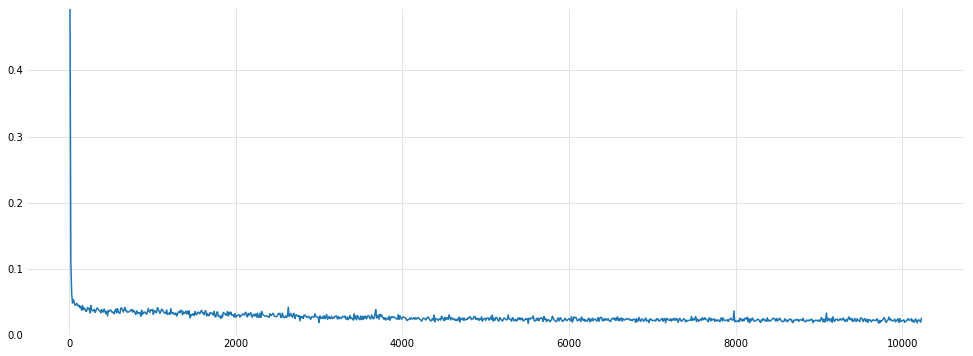

In [16]:
plt.ylim(ymax=np.amax(losses[1:])) # ignore first value(s) for scaling
plt.plot(indices, losses)
plt.show()

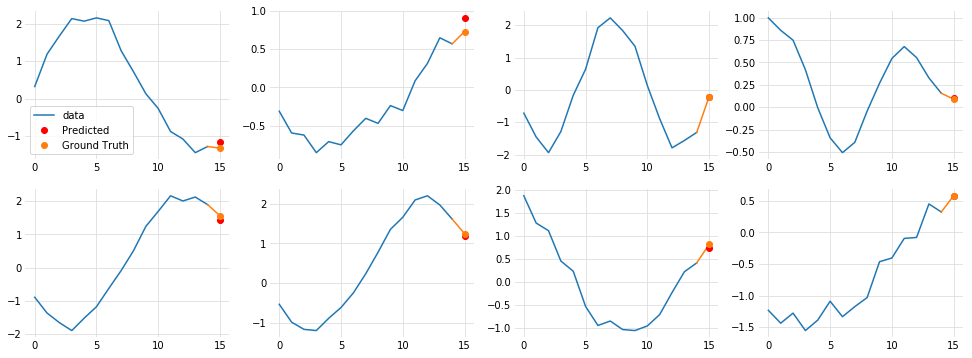

In [17]:
# execute multiple times to see different sample sequences
utils_display.picture_this_3(Yout_, evaldata, evallabels, SEQLEN)

<a name="benchmark"></a>
## Benchmark
Benchmark all the algorithms. This takes a while (approx. 10 min).

In [18]:
NB_EPOCHS = 10
sess.close()
models = [linear_model, DNN_model, CNN_model, RNN_model, RNN_model_N]
for model in models:
    # reset tensorflow graph: start from scratch
    tf.reset_default_graph()
    # instantiate the dataset
    features, labels, dataset_init_op, evaldataset_init_op = datasets(NB_EPOCHS)
    # instantiate model
    Yout, loss, eval_metrics, train_op = model_fn(features, labels, model)
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        # training loop
        sess.run([init, dataset_init_op])
        while True:
            try: sess.run(train_op)
            except tf.errors.OutOfRangeError: break
        # evaluation
        sess.run(evaldataset_init_op)
        eval_metrics_ = sess.run(eval_metrics)
        print(str(model))
        print(str(eval_metrics_))    

<function linear_model at 0x120c48598>
{'RMSE': 0.21979176, 'RMSErnd': 1.5322562, 'RMSEsal': 0.4106579, 'RMSEtfl': 0.3377973}
<function DNN_model at 0x109e81e18>
{'RMSE': 0.2095209, 'RMSErnd': 1.5527531, 'RMSEsal': 0.4106579, 'RMSEtfl': 0.3377973}
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
<function CNN_model at 0x109e818c8>
{'RMSE': 0.19297266, 'RMSErnd': 1.5345954, 'RMSEsal': 0.4106579, 'RMSEtfl': 0.3377973}
<function RNN_model at 0x109e817b8>
{'RMSE': 0.1627582, 'RMSErnd': 1.5594112, 'RMSEsal': 0.4106579, 'RMSEtfl': 0.3377973}
<function RNN_model_N at 0x109e81620>
{'RMSE': 0.15312791, 'RMSErnd': 1.5330957, 'RMSEsal': 0.4106579, 'RMSEtfl': 0.3377973}


Copyright 2018 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
[http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.